In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_xor_label(p):
  # XOR logic: if x * y is negative, return 0, else return 1
  return 1 if p[0] * p[1] < 0 else 0

# Function to generate XOR-labeled data
def classify_xor_data(num_samples: int, noise: float):
    points = []
    for _ in range(num_samples):
        x = np.random.uniform(-5, 5)
        y = np.random.uniform(-5, 5)

        # Padding for x and y
        padding = 0.3
        x += padding if x > 0 else -padding
        y += padding if y > 0 else -padding

        # Adding noise
        noise_x = np.random.uniform(-5, 5) * noise
        noise_y = np.random.uniform(-5, 5) * noise

        # Getting XOR label
        label = get_xor_label((x + noise_x, y + noise_y))
        points.append([x, y, label])

    return np.array(points)

In [3]:
# Generating datasets
train_data = classify_xor_data(num_samples=200, noise=0.1)
test_data = classify_xor_data(num_samples=200, noise=0.2)

In [4]:
X_train = train_data[:, :2]
y_train = train_data[:, 2]
X_test = test_data[:, :2]
y_test = test_data[:, 2]

In [77]:
# Plotting function
def plot_xor_data(X,y, title):
    plt.figure(figsize=(6, 6))

    # Plotting the points, using blue for label 1 and orange for label 0
    plt.scatter(X[y==1][:,0], X[y==1][:,1], color='blue', label='Label 1', edgecolor='k')
    plt.scatter(X[y==0][:,0], X[y==0][:,1], color='orange', label='Label 0', edgecolor='k')

    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid(True)
    plt.show()

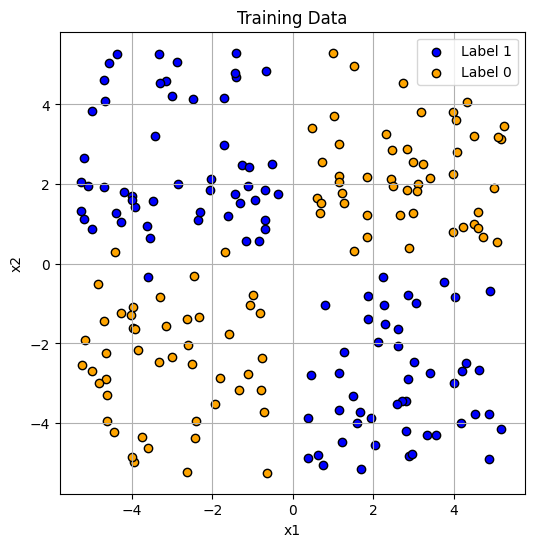

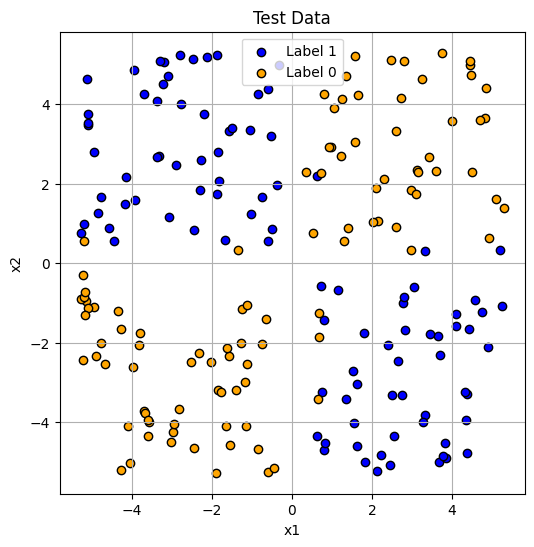

In [6]:
plot_xor_data(X_train, y_train, 'Training Data')
plot_xor_data(X_test, y_test, 'Test Data')

# (a) MLP with no regularization

In [7]:
import tensorflow.keras
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf

# Building MLP model
mlp = Sequential([
    InputLayer(shape=(2,)),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling and training the model
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp.fit(X_train, y_train, epochs=100, verbose=0)

In [8]:
test_results = mlp.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_results[1] * 100:.2f}%')
print(f'Test Loss: {test_results[0]}')

Test Accuracy: 96.00%
Test Loss: 0.12302599102258682


In [68]:
from matplotlib.colors import ListedColormap
def plot_decision_boundary(X, y, model,poly=None):
    plt.figure(figsize=(6, 6))

    # Definining the boundaries of the grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.04),
                         np.arange(y_min, y_max, 0.04))

    # Using the trained TensorFlow MLP model to predict on the grid
    grid = np.c_[xx.ravel(), yy.ravel()]
    if(poly):
        grid = poly.transform(grid)
    Z = model.predict(grid)
    Z = np.round(Z).reshape(xx.shape)

    # Plotting the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=ListedColormap(['blue', 'orange']))
    plt.contour(xx, yy, Z, colors='black', linewidths=0.2)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='orange', marker='^', edgecolors='k', label='Class 1')
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', marker='s', edgecolors='k', label='Class 0')

    # Adding labels and legend
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.legend()
    plt.show()

3091/3091 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


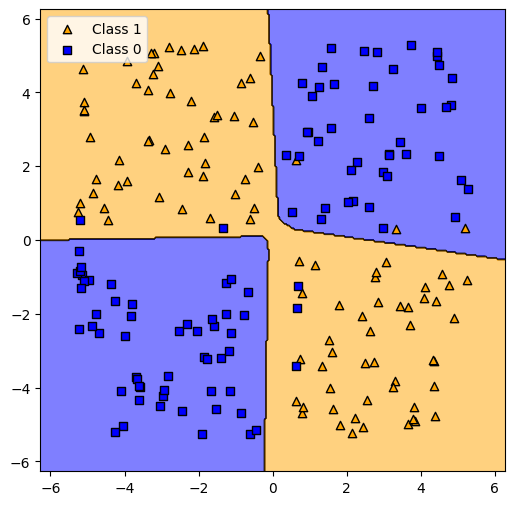

In [37]:
plot_decision_boundary(X_test, y_test, mlp)

# (b) ML with L1 regularization

In [41]:
X_train = train_data[:, :2]
y_train = train_data[:, 2]
X_test = test_data[:, :2]
y_test = test_data[:, 2]

In [43]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and validation sets
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# List of L1 penalty coefficients
l1_penalties = [0.001, 0.01, 0.1]

best_penalty = None
best_val_accuracy = 0

# Iterating over each L1 penalty coefficient
for l1_penalty in l1_penalties:
    mlp_l1 = Sequential([
        InputLayer(shape=(2,)),
        Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(l1_penalty)),
        Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(l1_penalty)),
        Dense(1, activation='sigmoid')
    ])

    mlp_l1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Training the model
    mlp_l1.fit(X_t, y_t, epochs=100, verbose=0)

    # Evaluating on the validation set
    val_loss, val_accuracy = mlp_l1.evaluate(X_val, y_val, verbose=0)

    print(f"L1 penalty: {l1_penalty}, Validation Accuracy: {val_accuracy:.4f}")

    # Keeping track of the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_penalty = l1_penalty

print(f"\nBest L1 penalty: {best_penalty}, Best Validation Accuracy: {best_val_accuracy:.4f}")

L1 penalty: 0.001, Validation Accuracy: 1.0000
L1 penalty: 0.01, Validation Accuracy: 0.9500
L1 penalty: 0.1, Validation Accuracy: 0.8333

Best L1 penalty: 0.001, Best Validation Accuracy: 1.0000


In [46]:
# Training on 0.001 penalty
mlp_l1 = Sequential([
        InputLayer(shape=(2,)),
        Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.001)),
        Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.001)),
        Dense(1, activation='sigmoid')
    ])

mlp_l1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
mlp_l1.fit(X_train, y_train, epochs=100, verbose=0)

In [47]:
test_results_l1 = mlp_l1.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_results_l1[1] * 100:.2f}%')
print(f'Test Loss: {test_results_l1[0]}')

Test Accuracy: 93.50%
Test Loss: 0.2762482762336731


3091/3091 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


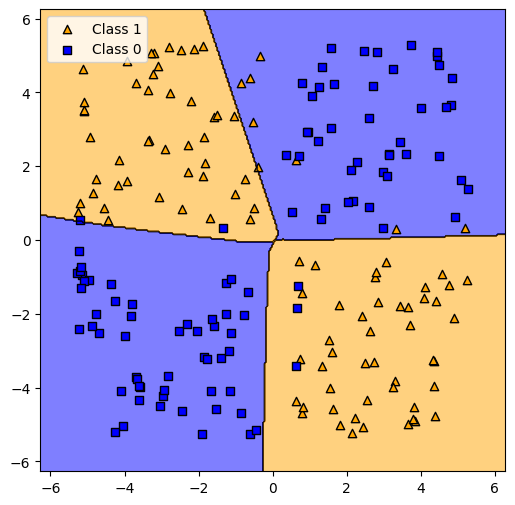

In [59]:
plot_decision_boundary(X_test, y_test, mlp_l1)

# (c) MLP with L2 regularization

In [51]:
# Splitting the data into training and validation sets
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

# List of L2 penalty coefficients
l2_penalties = [0.001, 0.01, 0.1]

best_penalty = None
best_val_accuracy = 0

# Iterating over each L1 penalty coefficient
for l2_penalty in l2_penalties:
    mlp_l2 = Sequential([
        InputLayer(shape=(2,)),
        Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_penalty)),
        Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_penalty)),
        Dense(1, activation='sigmoid')
    ])

    mlp_l2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Training the model
    mlp_l2.fit(X_t, y_t, epochs=100, verbose=0)

    # Evaluating on the validation set
    val_loss, val_accuracy = mlp_l2.evaluate(X_val, y_val, verbose=0)

    print(f"L2 penalty: {l2_penalty}, Validation Accuracy: {val_accuracy:.4f}")

    # Keeping track of the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_penalty = l2_penalty

print(f"\nBest L2 penalty: {best_penalty}, Best Validation Accuracy: {best_val_accuracy:.4f}")

L2 penalty: 0.001, Validation Accuracy: 0.9750
L2 penalty: 0.01, Validation Accuracy: 0.9875
L2 penalty: 0.1, Validation Accuracy: 0.9750

Best L2 penalty: 0.01, Best Validation Accuracy: 0.9875


In [52]:
# Building MLP model with L2 regularization with 0.01 penalty
mlp_l2 = Sequential([
    InputLayer(shape=(2,)),
    Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')
])

mlp_l2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp_l2.fit(X_train, y_train, epochs=100, verbose=0)

In [53]:
test_results_l2 = mlp_l2.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_results_l2[1] * 100:.2f}%')
print(f'Test Loss: {test_results_l2[0]}')

Test Accuracy: 95.50%
Test Loss: 0.259236216545105


3091/3091 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


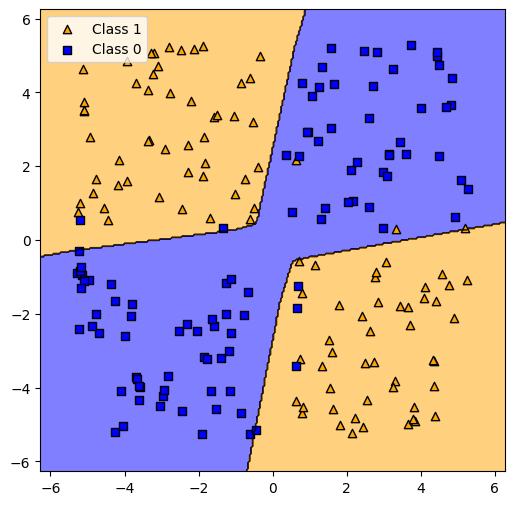

In [54]:
plot_decision_boundary(X_test, y_test, mlp_l2)

# (d) Logistic regression with additional features

In [60]:
X_train = train_data[:, :2]
y_train = train_data[:, 2]
X_test = test_data[:, :2]
y_test = test_data[:, 2]

In [73]:
from sklearn.preprocessing import PolynomialFeatures

# Generating polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [74]:
logistic=Sequential([
            InputLayer(shape=(X_train_poly.shape[1],)),
            Dense(1, activation='sigmoid')
        ])
logistic.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
logistic.fit(X_train_poly, y_train, epochs=100, verbose=0)

In [75]:
test_results_logistic = logistic.evaluate(X_test_poly, y_test)
print(f'Test Accuracy: {test_results_logistic[1] * 100:.2f}%')
print(f'Test Loss: {test_results_logistic[0]}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9347 - loss: 0.2753
Test Accuracy: 91.50%
Test Loss: 0.24801570177078247


3091/3091 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


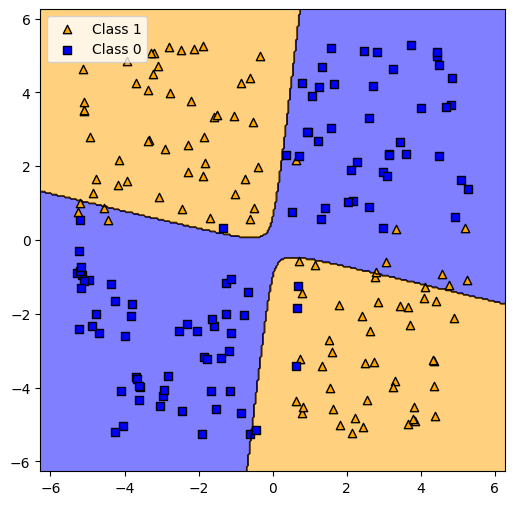

In [76]:
plot_decision_boundary(X_test, y_test, logistic, poly)

Observations:

(a) MLP(No regularization) According to result, we get a smooth decision boundary that closely follows the XOR pattern. It is flexible enough to capture the nonlinear nature of the XOR problem.

(b) MLP (L1 Regularization): L1 regularization encourages sparsity in weights, and the decision boundary is slightly less flexible compared to the basic MLP.

(c) MLP (L2 Regularization): L2 regularization tends to make the model weights smaller, leading to smoother decision boundaries than L1 regularization but potentially less overfitting compared to the basic MLP.

(d) Logistic Regression (with Polynomial Features): By adding non-linear features of degree 2, the logistic regression model successfully captures the XOR pattern with its smoother decision boundary.